In [ ]:
import pandas as pd
import numpy as np
import sys
import h5py
import yaml
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import balanced_accuracy_score

sys.path.append('/home/lugeon/eeg_project/scripts')

import seaborn as sns
sns.set_context("paper")
sns.set(font_scale = 1.6)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

In [11]:
result_dir = '/home/lugeon/eeg_project/results/loso_ft/autoencoder'
df_path = f'{result_dir}/res.csv'
df = pd.read_csv(df_path)
df['pred'] = (df.score >= 0.5).astype(int)
df.head()

,sid,tid,fid,ss,et,label,score,pred
0,0,79,20,3,303,1,0.509008,1
1,0,68,10,2,148,0,0.731559,1
2,0,72,5,2,280,1,0.996440,1
3,0,89,10,3,285,1,0.103928,0
4,0,45,10,2,119,1,0.901464,1


In [12]:
with open(f'{result_dir}/train_config.yaml') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
        
with h5py.File(config['data']['dset_kwargs']['hdf5_file'], 'r') as f:
        subjects = [s.decode('utf-8') for s in f['subject_name'][:]]

In [13]:
balanced_acc = df.groupby('sid').apply(lambda g: balanced_accuracy_score(g.label, g.pred))

rates = df.groupby('sid').apply(lambda g: roc_curve(g.label, g.score))
rates = rates.apply(lambda r: [r[0].tolist(), r[1].tolist()])

# mean area under the ROC curve
aucs = [auc(fpr, tpr) for (fpr, tpr) in rates]

In [14]:
print(f'LOSO Balanced Acc: {np.mean(balanced_acc) * 100 :.2f} +/- {np.std(balanced_acc) * 100:.2f}')
print(f'LOSO AUC-ROC: {np.mean(aucs) * 100 :.2f} +/- {np.std(aucs) * 100:.2f}')

LOSO Balanced Acc: 61.59 +/- 5.73
LOSO AUC-ROC: 65.69 +/- 7.32


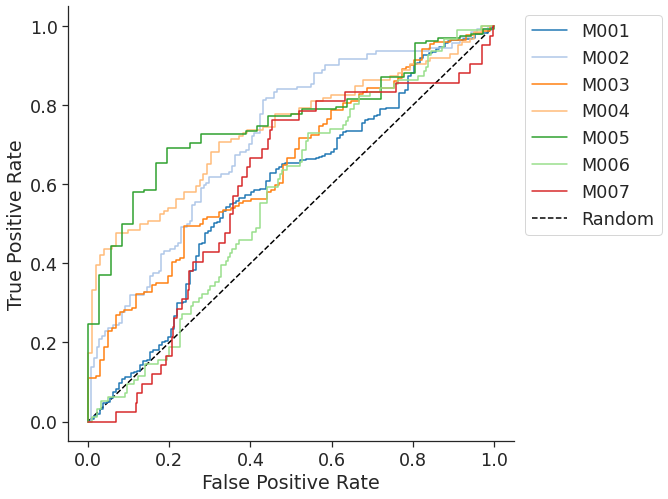

In [15]:
fig, ax = plt.subplots(figsize=(8, 8)) 
cmap = plt.get_cmap('tab20')

i = 0
for r, sname in zip(rates, subjects):
    fpr, tpr = r
    if fpr is not None:
        ax.plot(fpr, tpr, label=sname, color=cmap(i))
    i += 1
    
ax.plot([0, 1], [0, 1], label='Random', linestyle='--', color='black', zorder=0)

plt.legend(bbox_to_anchor=[1.35, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('roc.png', bbox_inches='tight')

plt.show()

In [16]:
trial_preds = df.groupby(['sid', 'tid']).pred.apply(
    lambda p: sum(p) / len(p)
    ).to_frame().reset_index().rename(columns={'pred': 'majority_score'})

trial_preds = trial_preds.merge(
    df[['sid', 'tid', 'label', 'et', 'ss']].drop_duplicates(['sid', 'tid']), 
    how='left', on=['sid', 'tid'])

trial_preds['majority_pred'] = (trial_preds.majority_score >= 0.5).astype(int)
trial_preds['correct'] = trial_preds.majority_pred == trial_preds.label

majority_acc = trial_preds.groupby('sid').apply(lambda g: balanced_accuracy_score(g.label, g.majority_pred))
print(f'Trial majority accuracy: {np.mean(majority_acc) * 100 :.2f} +/- {np.std(majority_acc) * 100:.2f}')

Trial majority accuracy: 60.70 +/- 6.46


In [26]:
baccs = []
support = []
for treshold in [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]:
    mask = (0.5 - abs(0.5 - df.score)) <= treshold
    df_th = df[mask]
    bacc = df_th.groupby('sid').apply(lambda g: balanced_accuracy_score(g.label, g.pred))
    support.append(df_th.shape[0])
    baccs.append(bacc.mean())

In [27]:
support

[2184, 1948, 1653, 1350, 944, 678]

In [28]:
baccs

[0.615894826838388,
 0.629585250747377,
 0.6376661161939309,
 0.6527176411810752,
 0.6183987600385061,
 0.6007904245956832]

### Error distribution

In [56]:
correct_trials = trial_preds[trial_preds.correct]
correct_ss_dist = correct_trials.ss.value_counts()
correct_ss_dist /= correct_ss_dist.sum()
correct_ss_dist.sort_index()

2    0.577093
3    0.422907
Name: ss, dtype: float64

In [57]:
incorrect_trials = trial_preds[~trial_preds.correct]
incorrect_ss_dist = incorrect_trials.ss.value_counts()
incorrect_ss_dist /= incorrect_ss_dist.sum()
incorrect_ss_dist.sort_index()

2    0.547445
3    0.452555
Name: ss, dtype: float64